# Glider Data via ERDDAP
*Compiled by Sage Lichtenwalner, Rutgers University, June 6, 2018*

*Revised by Lori Garzio (to work with Pangeo), Rutgers University, July 9, 2018*

*This example is largely based on a notebook by [Filipe Fernandes's](https://github.com/ioos/BioData-Training-Workshop/blob/master/notebooks/intro_errdapy-IOOS.ipynb), presented at the IOOS Biological Data Training Workshop. Thanks Filipe!*

ERDDAP data servers provide an easy to use RESTful API that make it easy to search for and request data.  There are many ERDDAP servers now available including [NOAA Coastwatch](erddap coastwatch), the [IOOS Glider DAC](https://data.ioos.us/gliders/erddap/index.html), and the  [OOI](http://oceanobservatories.org/erddap-server/).

For this example, we're going to grab OOI glider data that is stored in the IOOS Glider DAC.

A typical ERDDAP URL to request data looks like this:

[https://data.ioos.us/gliders/erddap/tabledap/whoi_406-20160902T1700.mat?depth,latitude,longitude,salinity,temperature,time&time>=2016-07-10T00:00:00Z&time<=2017-02-10T00:00:00Z
&latitude>=38.0&latitude<=41.0&longitude>=-72.0&longitude<=-69.0](https://data.ioos.us/gliders/erddap/tabledap/whoi_406-20160902T1700.mat?depth,latitude,longitude,salinity,temperature,time&time>=2016-07-10T00:00:00Z&time<=2017-02-10T00:00:00Z&latitude>=38.0&latitude<=41.0&longitude>=-72.0&longitude<=-69.0)

It's a mouthful, but it can easily be broken down into smaller parts.

* **server**: https://data.ioos.us/gliders/erddap/
* **protocol**: tabledap
* **dataet_id**: blue-20160818T1448.csv
* **variables**: depth,latitude,longitude,temperature,time
* **constraints**:
    - time>=2016-07-10T00:00:00Z
    - time<=2017-02-10T00:00:00Z
    - latitude>=38.0
    - latitude<=41.0
    - longitude>=-72.0
    - longitude<=-69.0

## We can use *erddapy* to help us make these URLs

![tar.png](https://imgs.xkcd.com/comics/tar.png)

In [1]:
from erddapy import ERDDAP

# Part 1 - Let's Grab Some Data

* Were going going to use the [IOOS Glider DAC](https://data.ioos.us/gliders/erddap/index.html)
  * It includes gliders from many providers, including OOI
  * The data is provided in profile format, which makes it easier to use
  
* If we know the dataset ID we're interested in, we can request data

In [2]:
server = 'https://data.ioos.us/gliders/erddap'

dataset_id = 'whoi_406-20160902T1700'

constraints = {
    'time>=': '2016-07-10T00:00:00Z',
    'time<=': '2017-02-10T00:00:00Z',
    'latitude>=': 38.0,
    'latitude<=': 41.0,
    'longitude>=': -72.0,
    'longitude<=': -69.0,
}

variables = [
 'depth',
 'latitude',
 'longitude',
 'salinity',
 'temperature',
 'time',
]

In [3]:
e = ERDDAP(
    server=server,
    protocol='tabledap',
    response='nc'
)

e.dataset_id=dataset_id
e.constraints=constraints
e.variables=variables

print(e.get_download_url())

https://data.ioos.us/gliders/erddap/tabledap/whoi_406-20160902T1700.nc?depth,latitude,longitude,salinity,temperature,time&time>=1468108800.0&time<=1486684800.0&latitude>=38.0&latitude<=41.0&longitude>=-72.0&longitude<=-69.0


## Talk is cheap, so get me the data!

There are a few methods you can use to get the data in a usable format:
* *to_pandas()* 
* *to_xarray()*

In [4]:
df = e.to_pandas(
    index_col='time',
    parse_dates=True,
    skiprows=(1,)  # units information can be dropped.
).dropna()

df.head()

,depth,latitude,longitude,salinity,temperature
time,,,,,
2016-09-03 20:15:46,5.35,40.990881,-71.12439,32.245422,20.6620
2016-09-03 20:15:46,6.09,40.990881,-71.12439,32.223183,20.6512
2016-09-03 20:15:46,6.72,40.990881,-71.12439,32.237950,20.6047
2016-09-03 20:15:46,7.37,40.990881,-71.12439,32.235470,20.5843
2016-09-03 20:15:46,8.43,40.990881,-71.12439,32.224503,20.5691


In [5]:
ds = e.to_xarray(decode_times=False)

ds['temperature']

<xarray.DataArray 'temperature' (row: 48490)>
array([20.662 , 20.6512, 20.6047, ..., 18.9417, 19.0459, 19.2737],
      dtype=float32)
Coordinates:
    depth      (row) float32 ...
    latitude   (row) float64 ...
    longitude  (row) float64 ...
    time       (row) float64 ...
Dimensions without coordinates: row
Attributes:
    _ChunkSizes:          73
    actual_range:         [ 9.9473 22.6177]
    ancillary_variables:  qartod_temperature_climatological_flag qartod_tempe...
    colorBarMaximum:      32.0
    colorBarMinimum:      0.0
    instrument:           instrument_ctd
    ioos_category:        Temperature
    long_name:            Sea Water Temperature
    observation_type:     measured
    platform:             platform
    standard_name:        sea_water_temperature
    units:                Celsius
    valid_max:            40.0
    valid_min:            -5.0

## Let's plot the data

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

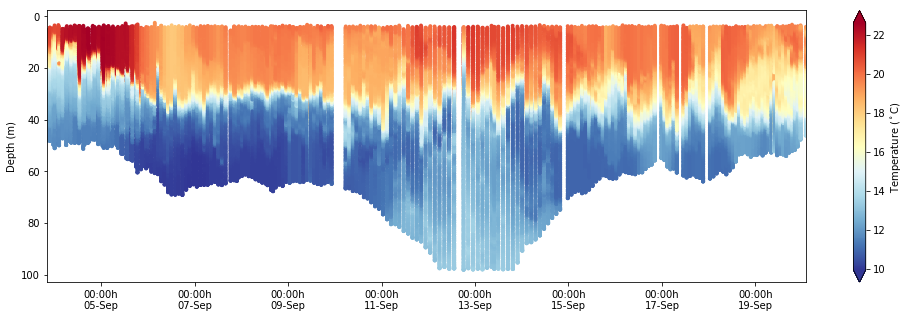

In [7]:
fig, ax = plt.subplots(figsize=(17, 5))
kw = dict(s=15, c=df['temperature'], marker='o', edgecolor='none')
cs = ax.scatter(df.index, df['depth'], **kw, cmap='RdYlBu_r')

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%H:%Mh\n%d-%b')
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_ylabel('Depth (m)');

# Part 2 - Searching for Datasets

* [ERDDAP](https://data.ioos.us/gliders/erddap/search/advanced.html?page=1&itemsPerPage=1000) also provides a way to search for datasets
* And we can use *erddapy* to search for datasets interactively

In [8]:
e = ERDDAP(
    server='https://data.ioos.us/gliders/erddap'
)

In [9]:
import pandas as pd

# Grab every dataset available
datasets = pd.read_csv(e.get_search_url(response='csv', search_for='all'))

In [10]:
'We have {} tabledap, {} griddap, and {} wms endpoints.'.format(
    len(set(datasets['tabledap'].dropna())),
    len(set(datasets['griddap'].dropna())),
    len(set(datasets['wms'].dropna()))
)

'We have 443 tabledap, 0 griddap, and 0 wms endpoints.'

In [11]:
datasets.head()

,griddap,Subset,tabledap,Make A Graph,wms,files,Title,Summary,FGDC,ISO 19115,Info,Background Info,RSS,Email,Institution,Dataset ID
0,NaN,https://data.ioos.us/gliders/erddap/tabledap/a...,https://data.ioos.us/gliders/erddap/tabledap/a...,https://data.ioos.us/gliders/erddap/tabledap/a...,NaN,NaN,* The List of All Active Datasets in this ERDD...,This dataset is a table which has a row of inf...,NaN,NaN,https://data.ioos.us/gliders/erddap/info/allDa...,https://data.ioos.us/gliders/erddap,NaN,NaN,IOOS Glider DAC,allDatasets
1,NaN,https://data.ioos.us/gliders/erddap/tabledap/a...,https://data.ioos.us/gliders/erddap/tabledap/a...,https://data.ioos.us/gliders/erddap/tabledap/a...,NaN,NaN,All aoml Gliders,Seaglider data gathered as part of the Sustain...,https://data.ioos.us/gliders/erddap/metadata/f...,https://data.ioos.us/gliders/erddap/metadata/i...,https://data.ioos.us/gliders/erddap/info/allao...,http://data.ioos.us/gliders/erddap/,https://data.ioos.us/gliders/erddap/rss/allaom...,https://data.ioos.us/gliders/erddap/subscripti...,National Oceanic and Atmospheric Administratio...,allaomlGliders
2,NaN,https://data.ioos.us/gliders/erddap/tabledap/a...,https://data.ioos.us/gliders/erddap/tabledap/a...,https://data.ioos.us/gliders/erddap/tabledap/a...,NaN,NaN,All aoos Gliders,Shipboard observations of marine mammal distri...,https://data.ioos.us/gliders/erddap/metadata/f...,https://data.ioos.us/gliders/erddap/metadata/i...,https://data.ioos.us/gliders/erddap/info/allao...,http://data.ioos.us/gliders/erddap/,https://data.ioos.us/gliders/erddap/rss/allaoo...,https://data.ioos.us/gliders/erddap/subscripti...,"University of Alaska Fairbanks, College of Fis...",allaoosGliders
3,NaN,https://data.ioos.us/gliders/erddap/tabledap/a...,https://data.ioos.us/gliders/erddap/tabledap/a...,https://data.ioos.us/gliders/erddap/tabledap/a...,NaN,NaN,All bios Gliders,The Bermuda Institute of Ocean Sciences MAGIC ...,https://data.ioos.us/gliders/erddap/metadata/f...,https://data.ioos.us/gliders/erddap/metadata/i...,https://data.ioos.us/gliders/erddap/info/allbi...,http://data.ioos.us/gliders/erddap/,https://data.ioos.us/gliders/erddap/rss/allbio...,https://data.ioos.us/gliders/erddap/subscripti...,Bermuda Institute of Ocean Sciences,allbiosGliders
4,NaN,https://data.ioos.us/gliders/erddap/tabledap/a...,https://data.ioos.us/gliders/erddap/tabledap/a...,https://data.ioos.us/gliders/erddap/tabledap/a...,NaN,NaN,All corie Gliders,Slocum glider dataset gathered as part of the ...,https://data.ioos.us/gliders/erddap/metadata/f...,https://data.ioos.us/gliders/erddap/metadata/i...,https://data.ioos.us/gliders/erddap/info/allco...,http://data.ioos.us/gliders/erddap/,https://data.ioos.us/gliders/erddap/rss/allcor...,https://data.ioos.us/gliders/erddap/subscripti...,Oregon Health & Science University,allcorieGliders


## Let's refine our search

Let's narrow the search area, time span, and look for *sea_water_temperature* only.

In [12]:
kw = {
    'standard_name': 'sea_water_temperature',
    'min_lon': -72.0,
    'max_lon': -69.0,
    'min_lat': 38.0,
    'max_lat': 41.0,
    'min_time': '2018-01-10T00:00:00Z',
    'max_time': '2019-01-10T00:00:00Z',
    'cdm_data_type': 'trajectoryprofile'
}

In [13]:
search_url = e.get_search_url(response='csv', **kw)
print(search_url)

# Grab the results
search = pd.read_csv(search_url)

# Extract the IDs
gliders = search['Dataset ID'].values

msg = 'Found {} Glider Datasets:\n\n{}'.format
print(msg(len(gliders), '\n'.join(gliders)))

https://data.ioos.us/gliders/erddap/search/advanced.csv?page=1&itemsPerPage=1000&protocol=(ANY)&cdm_data_type=trajectoryprofile&institution=(ANY)&ioos_category=(ANY)&keywords=(ANY)&long_name=(ANY)&standard_name=sea_water_temperature&variableName=(ANY)&minLon=-72.0&maxLon=-69.0&minLat=38.0&maxLat=41.0&minTime=1515542400.0&maxTime=1547078400.0
Found 6 Glider Datasets:

allrutgersGliders
cp_336-20180126T0000
cp_339-20180126T0000
cp_380-20180126T0000
sp022-20180422T1229
sp066-20171129T1616


# Part 3 - Dataset Metadata

Once we know the *Dataset IDs* we can explore its metadata with `get_info_url()`

In [14]:
info_url = e.get_info_url(dataset_id=gliders[2], response='csv')
info = pd.read_csv(info_url)

print(gliders[2])
info.head(10) # First 10 attributes

cp_339-20180126T0000


,Row Type,Variable Name,Attribute Name,Data Type,Value
0,attribute,NC_GLOBAL,acknowledgment,String,Funding provided by the National Science Found...
1,attribute,NC_GLOBAL,cdm_data_type,String,TrajectoryProfile
2,attribute,NC_GLOBAL,cdm_profile_variables,String,"profile_id, time, latitude, longitude, time_uv..."
3,attribute,NC_GLOBAL,cdm_trajectory_variables,String,"trajectory, wmo_id"
4,attribute,NC_GLOBAL,contributor_name,String,"Paul Matthias,Peter Brickley,Sheri White,Diana..."
5,attribute,NC_GLOBAL,contributor_role,String,"CGSN Program Manager,CGSN Operations Engineer,..."
6,attribute,NC_GLOBAL,Conventions,String,"Unidata Dataset Discovery v1.0, COARDS, CF-1.6"
7,attribute,NC_GLOBAL,creator_email,String,kerfoot@marine.rutgers.edu
8,attribute,NC_GLOBAL,creator_name,String,John Kerfoot
9,attribute,NC_GLOBAL,creator_url,String,http://www.whoi.edu/ooi_cgsn/home


In [15]:
# Let's pull out the values for one of the variables
cdm_profile_variables = info.loc[
    info['Attribute Name'] == 'cdm_profile_variables', 'Value'
]

print(''.join(cdm_profile_variables))

profile_id, time, latitude, longitude, time_uv, lat_uv, lon_uv, u, v


## Finding variable names using attributes

In [16]:
# Find a variable name based on it's CF Compliant standard name
e.get_var_by_attr(
    dataset_id='cp_335-20170116T1459',
    standard_name='sea_water_temperature'
)

['temperature']

In [17]:
# Now let's find a few of them at once
standard_names=['sea_water_temperature', 'sea_water_practical_salinity']
variables = e.get_var_by_attr(
    dataset_id=dataset_id, 
    standard_name=lambda v: v in standard_names
)
variables

['temperature', 'salinity']

## Finding coordinate variables

In [18]:
axis = e.get_var_by_attr(
    dataset_id='cp_339-20180126T0000',
    axis=lambda v: v in ['X', 'Y', 'Z', 'T']
)
axis

['precise_lon',
 'latitude',
 'time',
 'precise_time',
 'longitude',
 'depth',
 'precise_lat',
 'pressure']

# Putting everything together

Let's find all of the gliders that flew within the Pioneer Array during 2018.

In [19]:
constraints = {
    'time>=': '2018-01-01T00:00:00Z',
    'time<=': '2019-01-01T00:00:00Z',
    'latitude>=': 38.0,
    'latitude<=': 41.0,
    'longitude>=': -72.0,
    'longitude<=': -69.0,
}

variables = [
 'depth',
 'latitude',
 'longitude',
 'salinity',
 'temperature',
 'time',
]

In [20]:
from requests.exceptions import HTTPError

def download_csv(url):
    return pd.read_csv(
        url, index_col='time', parse_dates=True, skiprows=[1]
)

dfs = {}
for glider in gliders:
    print(glider)
    try:
        download_url = e.get_download_url(
            dataset_id=glider,
            protocol='tabledap',
            variables=variables,
            response='csv',
            constraints=constraints
        )
    except HTTPError:
        continue
    dfs.update({glider: download_csv(download_url)})

allrutgersGliders
cp_336-20180126T0000
cp_339-20180126T0000
cp_380-20180126T0000
sp022-20180422T1229
sp066-20171129T1616


We can use [Folium](http://python-visualization.github.io/folium/) to create an interactive map of all of the glider tracks using leaflet.js.

In [21]:
import folium

In [22]:
def plot_track(df, name, color='orange'):
    df = df.reset_index().drop_duplicates(['latitude','longitude'], keep='first').sort_values('time')

    locations = list(zip(df['latitude'].values, df['longitude'].values))
    folium.PolyLine(
        locations=locations,
        color=color,
        weight=8,
        opacity=0.7,
        tooltip=name
    ).add_to(m)
    print(color)


In [23]:
import matplotlib.colors as mc
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
print(colors)

tiles = ('http://services.arcgisonline.com/arcgis/rest/services/'
         'World_Topo_Map/MapServer/MapServer/tile/{z}/{y}/{x}')

m = folium.Map(location=(40.3052, -70.8833), zoom_start=7,
               tiles=tiles, attr='ESRI')

k=0
for name, df in list(dfs.items()):
    plot_track( df, name, color=mc.to_hex(colors[k]) )
    k = k+1;

m #Display the map

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
#1f77b4
#ff7f0e
#2ca02c
#d62728
#9467bd


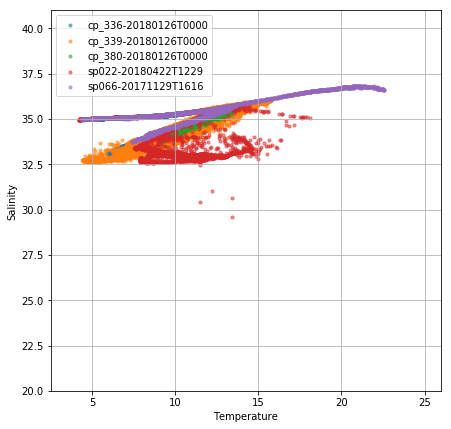

In [24]:
def glider_scatter(df, ax, glider):
    ax.scatter(df['temperature'], df['salinity'], s=10, alpha=0.5, label=glider)
    
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_ylabel('Salinity')
ax.set_xlabel('Temperature')
ax.grid(True)

for glider, df in dfs.items():
    glider_scatter(df, ax, glider)
    
leg = ax.legend()
ax.set_ylim(20, 41)
ax.set_xlim(2.5, 26);

# References

* Check out the [erddapy documentation](https://pyoceans.github.io/erddapy/) for more information on using the library, especially the [Quick Intro](https://pyoceans.github.io/erddapy/quick_intro.html).